# Měření velikosti zahřívané součátky
Tento úkol je zaměřen na využití kombinace dat z obyčejné RGB kamery a termokamery. Jako zahřívaná součástka bylo využito zařízení **Raspberry Pi 2 (Model B)** společně s **parazitními 2A rezistory** připojeny v USB.

Úkol má za cíl oživit dovednosti studentů při práci s obrazem, jakými jsou například projektivní transformace, segmentace nejen v barevných kanálech nebo měření velikostí v reálných jednotkách.

<img src="images/vv.png" width="50%"/>

### Import knihoven a konfigurace

In [1]:
%run ../svz.ipynb

from scipy.spatial import distance

In [3]:
def normalized_image(img):
    # Dejte si pozor, že cv2.normalize nalezne minimální/maximální hodnotu v obraze vůči kterým normalizuje a tento vstup nelze změnit.
    # Můžeme pouze nastavit nové minimum a maximum. Později v úkolu budete muset napsat svoji "chytřejší" normalizaci.
    scaled = np.zeros_like(img)
    cv2.normalize(img, scaled, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return scaled.astype('uint8')

def to_3_channels(image_one_channel):
    h,w = image_one_channel.shape
    image3 = np.zeros((h,w,3), dtype=np.uint8)
    image3[:,:,0] = image_one_channel
    image3[:,:,1] = image_one_channel
    image3[:,:,2] = image_one_channel
    return image3

def load_termo_csv(file_path):
    return np.genfromtxt(file_path, delimiter=';')[:, :-1]

## Úkol
K obrazové práci nad zahřívanou součástky jsou k dispozici nasnímaná data z rgb kamery a data reálných teplot z termokamery. Oboje je dostupné ve složce `data/`.

Za úkol je možné získat až **8 bodů**.

### 1) Načtěte data
Načtěte obrazová data ve formátu `png` a data teplot ve formátu `csv`. Data teplot obsahují reálné hodnoty teplot v jednotkách **°C** s přesností na desetinu stupně. Vhodně zobrazte jak data **obrazová**, tak data **teplot** obrázkem.

<div style="color: blue; text-align: right">[ 0,5 bodu ]</div>

In [4]:
img_png = cv2.imread('./data/data_rgb.png')
img_csv = img_csv = np.genfromtxt('./data/data_temps.csv', delimiter=';')[:, :-1]

plot_images(img_png, img_csv)

### 2) Vypište hodnoty několika teplot
Zvolte v obraze **3 body** a vypište hodnoty teploty v těchto bodech. Snažte se najít místa s **nejvyššími** teplotami.

<div style="color: blue; text-align: right">[ 0,5 bodu ]</div>

In [5]:
points = [(285, 480), (292, 287), (340, 195), (333, 298)]

for point in points:
    print(img_csv[point])

67.9
47.8
46.4
45.7


### 3) Namapujte termosnímek na RGB
Uvědomte si, že snímky **nejsou stejně velké** ani foceny ze **stejného úhlu**. Pamatujte, že je **důležité** uvědomit si **správně rovinu**, ve které pracujeme. Zobrazte jak obrázek RGB, tak namapovaný termosnímek.

Klíčová slova:
- přiřazení dvojic bodů
- hledání transformační matice
- warpování termosnímku na perspektivu RGB

<div style="color: blue; text-align: right">[ 1,5 bodu ]</div>

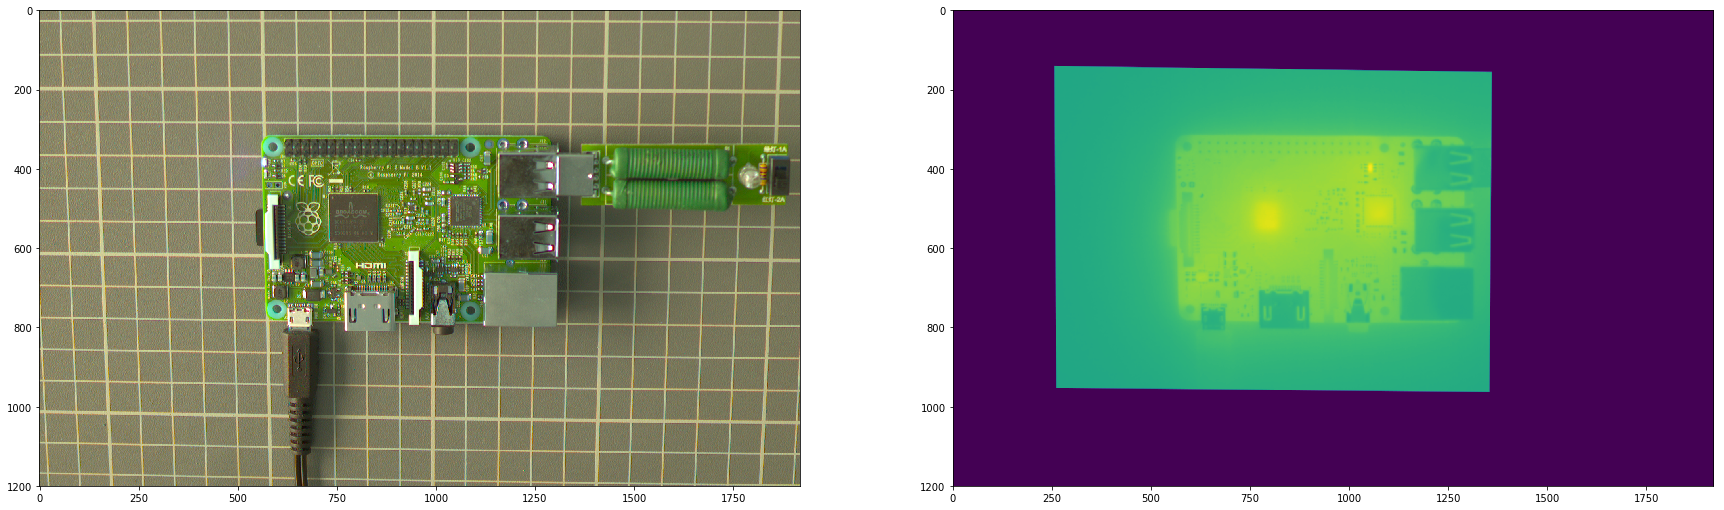

In [6]:
# select_image_points(img_png)
# [(590, 345), (1088, 346), (1089, 758), (599, 753)]
png_points = np.array([(590, 345), (1088, 346), (1089, 758), (599, 753)])

# crop the image to remove the USB resistors
# this is going to be usefull in task 4)
img_csv_rasppi = crop(img_csv, 0, 200, 400, 500)

# select_image_points(normalized_image(img_csv_rasppi))
# [(120, 73), (301, 71), (302, 224), (123, 224)]
csv_points = np.array([(120, 73), (301, 71), (302, 224), (123, 224)])

# get transformation matrix
H, mask = cv2.findHomography(csv_points, png_points)

# get png image size
height, width, channels = img_png.shape
dsize = (width, height)

img_csv_warped = cv2.warpPerspective(img_csv_rasppi, H, dsize)

plot_images(img_png, img_csv_warped)

### 4) Segmentujte v termosnímku
Pomocí rozsahu **reálných teplot** (ne jasových hodnot) vytvořte binární masku, která bude obsahovat **celé Raspberry Pi** bez připojených USB rezistorů. Masku zobrazte.

<div style="color: blue; text-align: right">[ 1,5 bodu ]</div>

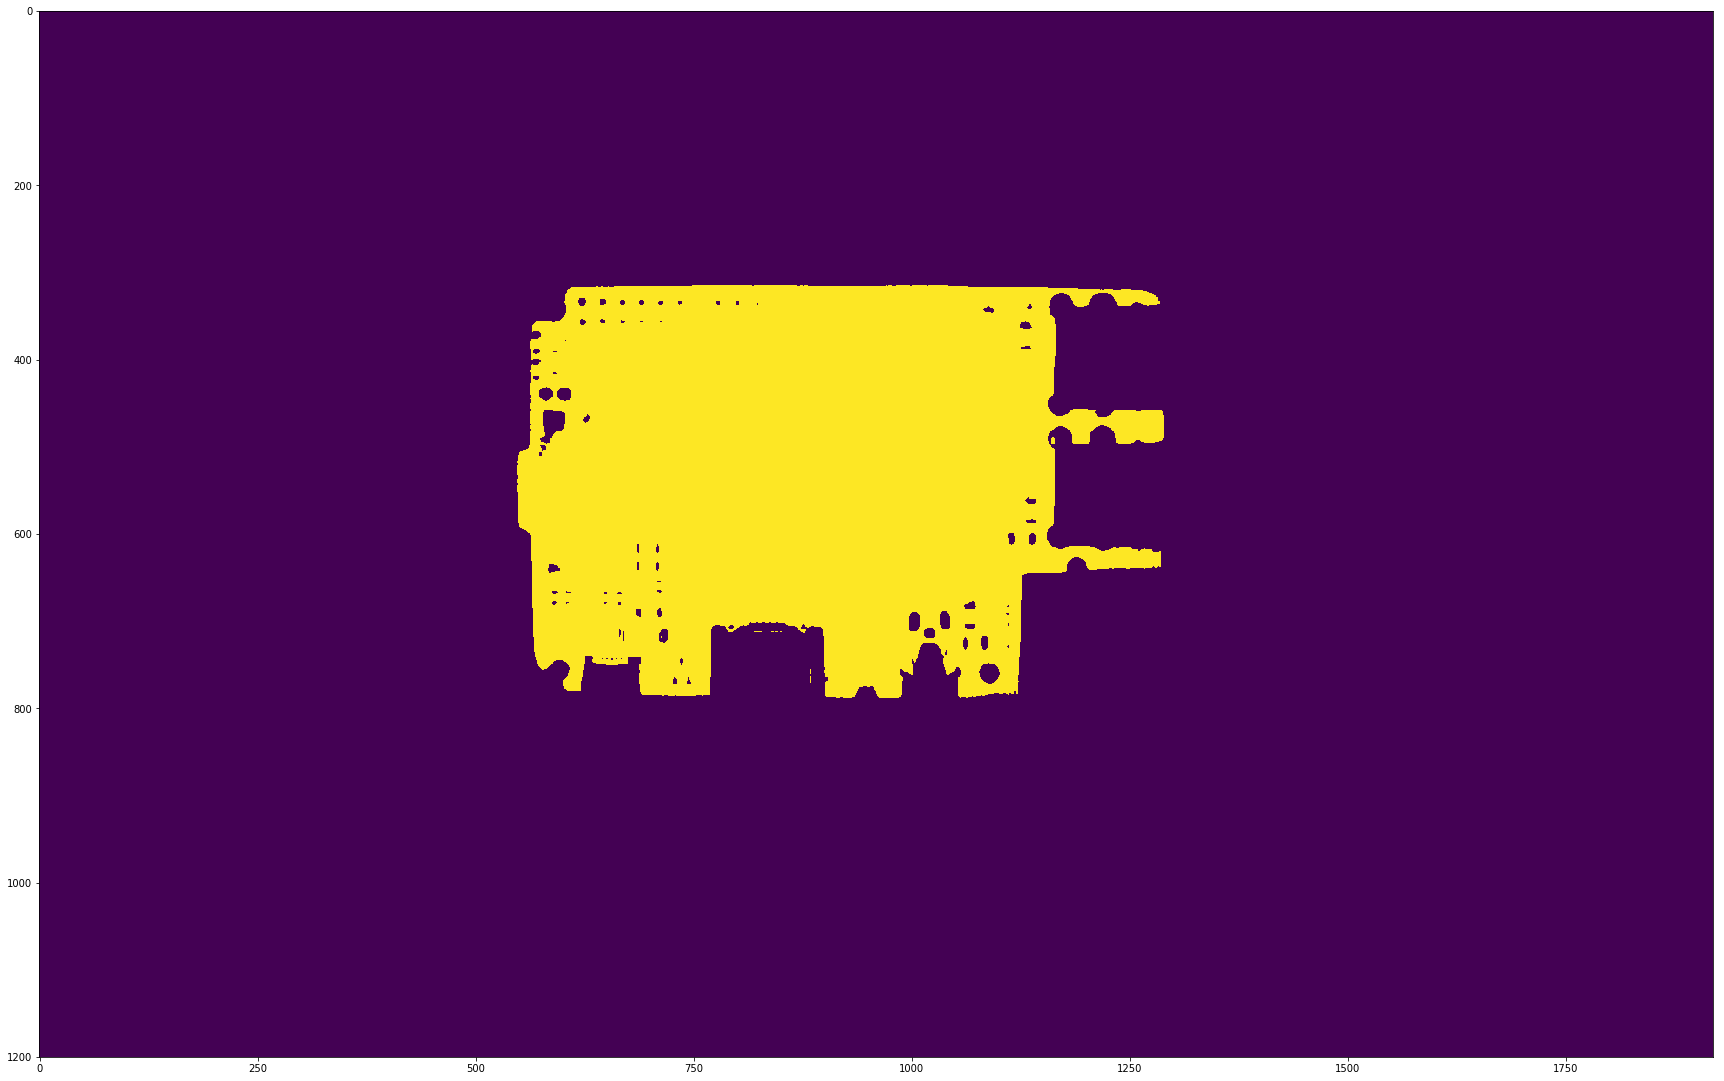

In [7]:
# crop the image to remove the USB resistors
# img_csv_rasppi = crop(img_csv, 0, 200, 400, 500)
mask = segmentation_two_thresholds(img_csv_warped, 37, 50)
plot_images(mask)

### 5) Aplikujte data teplot na RGB obraz
Pomocí výše vytvořené **binární masky** segmentujte **data teplot**. Ty následně zobrazte pomocí vybrané [JET colormapy](https://docs.opencv.org/3.2.0/d3/d50/group__imgproc__colormap.html). Jako dílčí výstup **vytvořte funkci** pro **min-max normalizaci** teplotních hodnot obrazu, která přímá na vstupu **min, max, newmin, newmax**. Bude se hodit při aplikaci colormapy. Dále se vám může hodit funkce `to_3_channels()` k snadnějším bitovým operacím. Její využití však není podmínkou, způsobů získání výsledku je více.

Snímek by měl vypadat následovně (nenechte se zmást zobrazením BGR $\leftrightarrow$ RGB při používání matplotlibu).

<img src="images/fuse.png" width="50%"/>

Klíčová slova:
- min-max normalizace
- aplikace colormapy
- segmentace pomocí masky
- vážené spojení dvou obrazů

<div style="color: blue; text-align: right">[ 1,5 bodu ]</div>

In [8]:
# Min-max normalization
def min_max_norm(image, old_min, old_max, new_min, new_max):
    new_img = np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            new_img[i][j] = new_min + ((image[i][j]-old_min)*(new_max-new_min)/(old_max-old_min))
            # source: https://en.wikipedia.org/wiki/Normalization_(statistics)
            
    return new_img

In [11]:
# get min temp from the original (not warped) image, because the min in the warped image is 0
old_min = np.min(img_csv_rasppi)
old_max = np.max(img_csv_warped)
# the +4 constant was found experimentaly to get a better result
img_norm_to255 = min_max_norm(img_csv_warped, old_min+4, old_max, 0, 255)

# convert both images to 3 channel images before masking (it didn't work without this)
img_3channels = to_3_channels(img_norm_to255)
mask_3channels = to_3_channels(mask)
img_masked = logical_and(img_3channels, mask_3channels)

img_jet = cv2.applyColorMap(img_masked, cv2.COLORMAP_JET)

# apply mask again, because the applyColorMap transformed [0, 0, 0] values to [128, 0, 0] values
img_rasppi_temps = logical_and(img_jet, mask_3channels)

plot_images(cv2.cvtColor(img_rasppi_temps, cv2.COLOR_BGR2RGB))

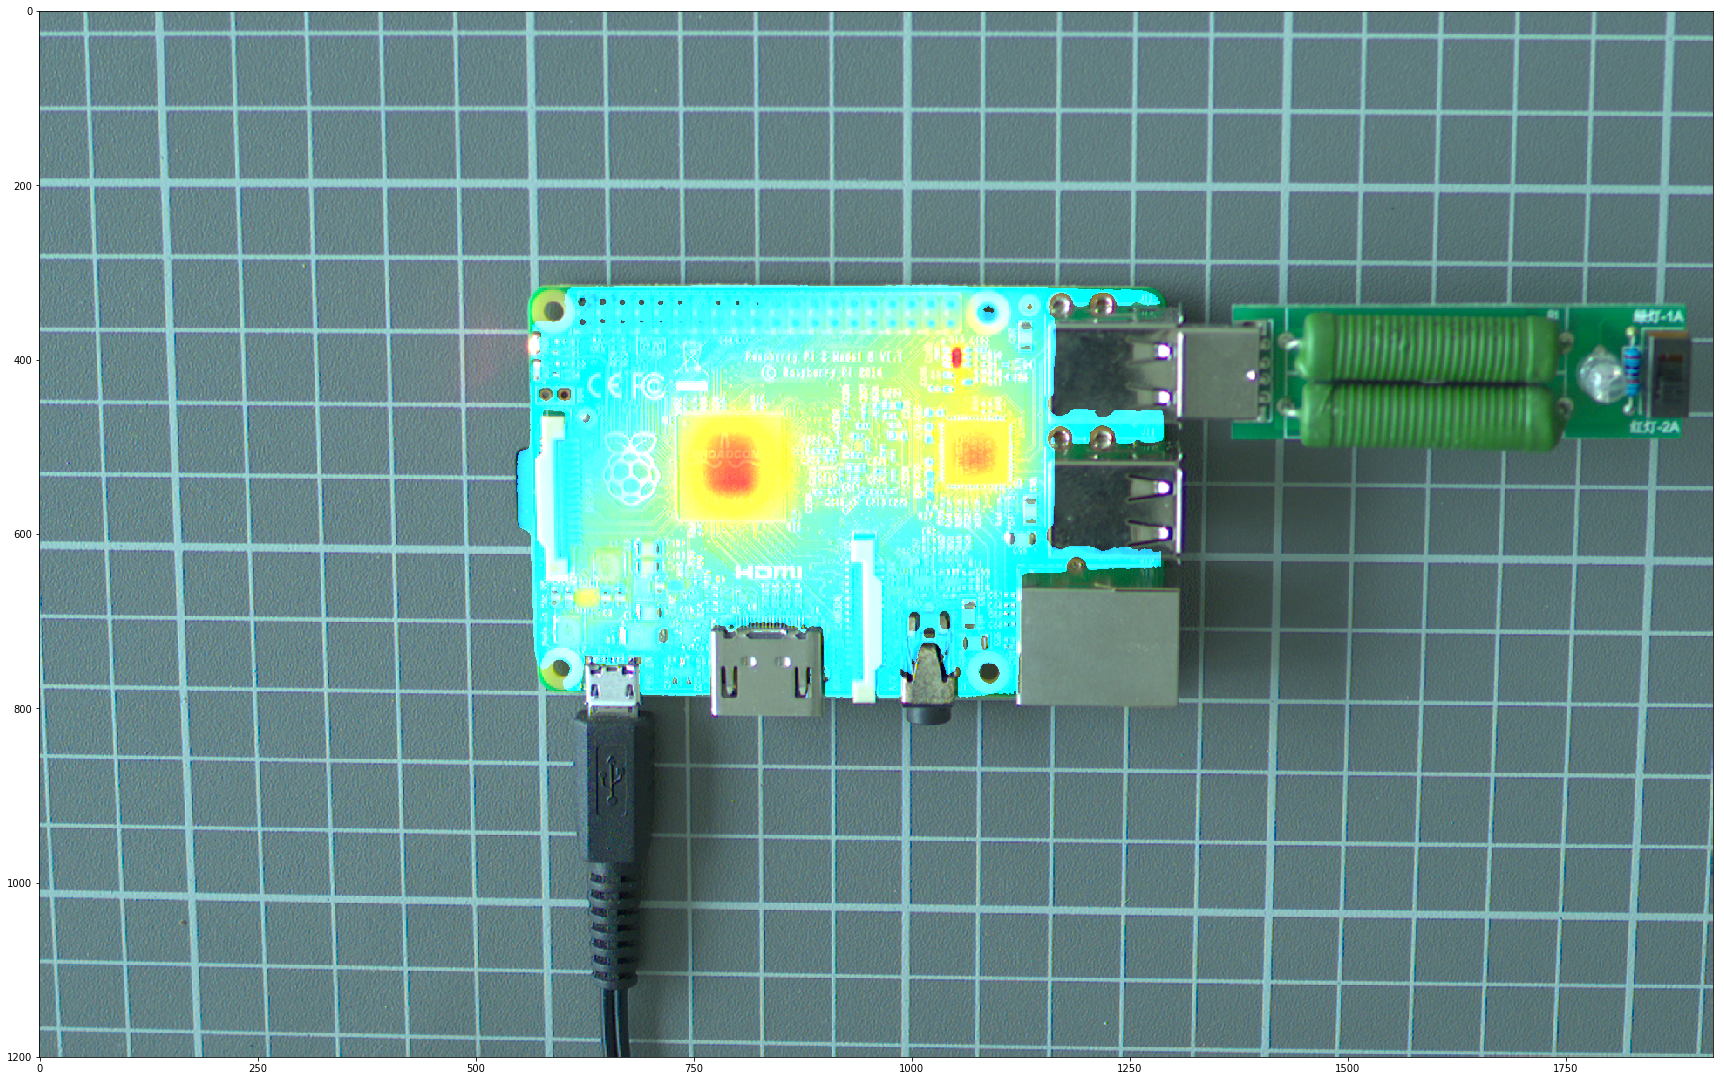

In [12]:
# combine both images
img_combined = cv2.addWeighted(img_png, 1, img_rasppi_temps, 1, 0)

plot_images(cv2.cvtColor(img_combined, cv2.COLOR_BGR2RGB))

### 6) Segmentujte součástky
Využijte teplotní data k segmentaci **pouze 2 zahřívajících se** součástek - mikročipů. Zajímá nás plocha, která má teplotu vyšší než **43 °C**.

Při jejich hledání **využijte** informaci, že hledané mikročipy mají přibližně tvar čtverce.

<div style="color: blue; text-align: right">[ 1,5 bodu ]</div>

In [24]:
# find countours
overheating_mask = segmentation_one_threshold(img_csv_rasppi, 43)
conts_drawn, _, conts = contours(cv2.cvtColor(to_3_channels(overheating_mask), cv2.COLOR_BGR2GRAY))
plot_images(conts_drawn)
# based on the temp data, one of the microchips looks more like a circle than a square (-> I will use aspect_ratios)

In [19]:
# Function from tutorial 10 (svz notebook contains a different version of this function)

# Poměr stran
def aspect_ratio(cont):
    dims = cv2.minAreaRect(cont)[1]
    min_diameter = min(dims)
    max_diameter = max(dims)
    return ShapeDescriptors.aspect_ratio(min_diameter, max_diameter)

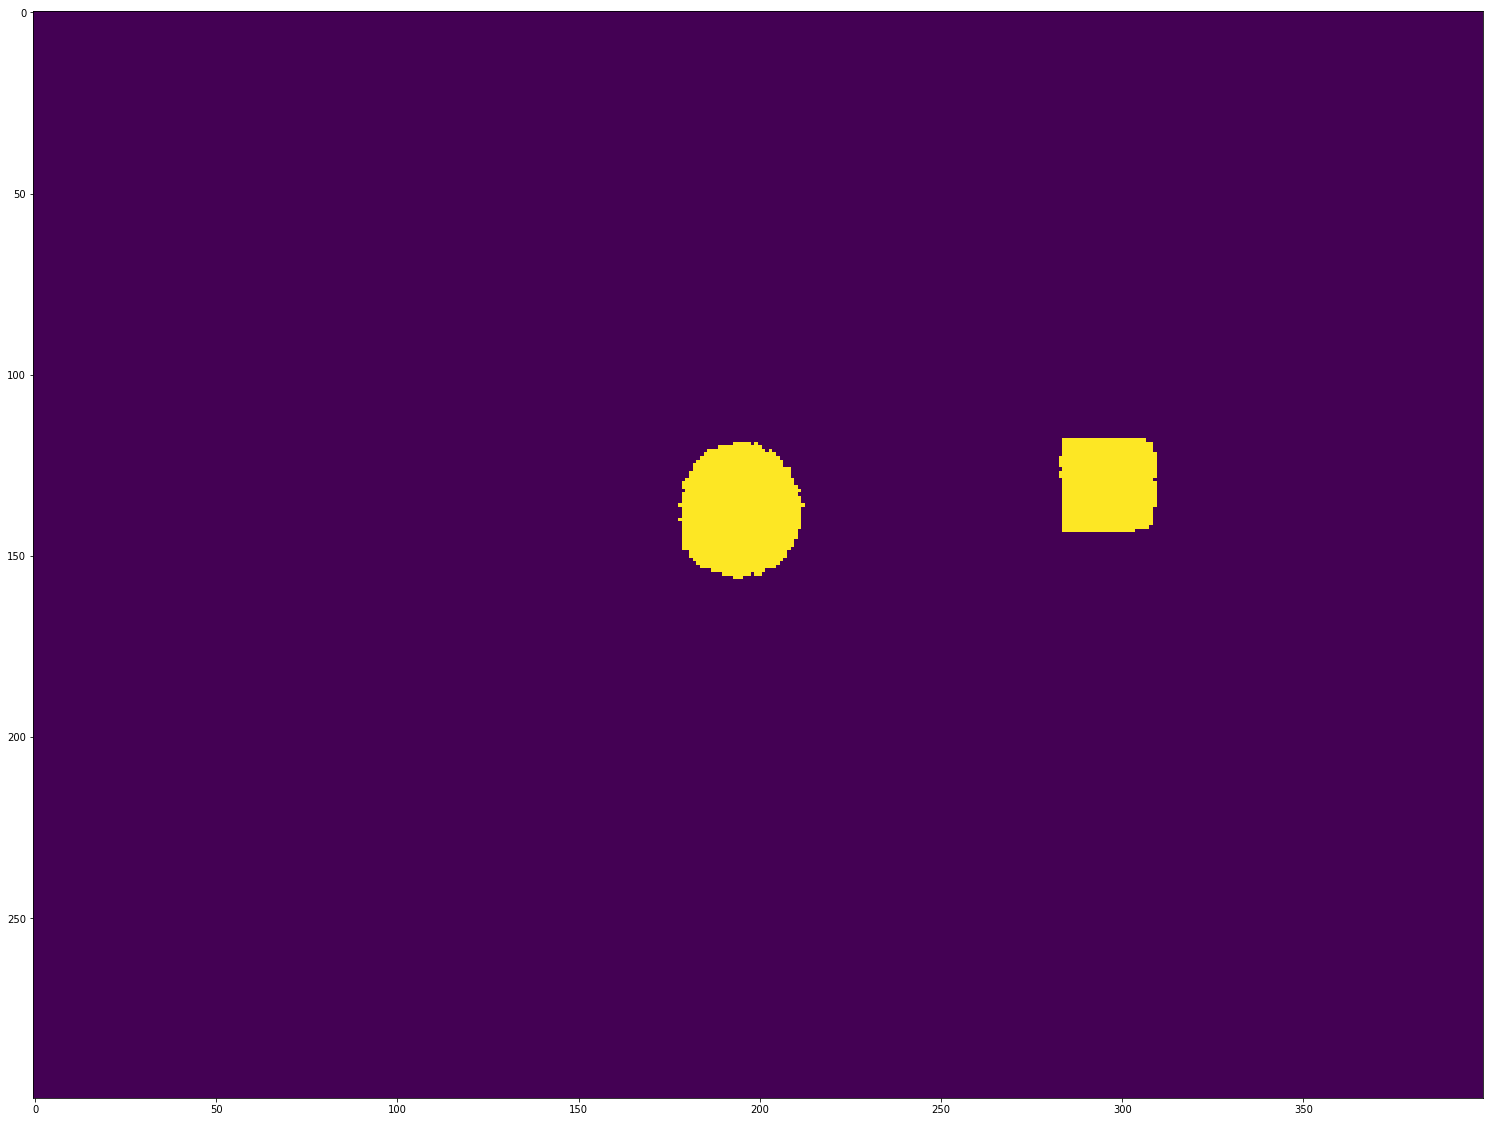

In [44]:
# check aspect ratio of each contour to get only square-like contours

square_aspect_ratio = 1
tolerance = 0.11

square_conts = []
for cont in conts:
    if np.isclose(aspect_ratio(cont), square_aspect_ratio, tolerance):
        square_conts.append(cont)
 
# plot the found contours
conts_drawn = cv2.drawContours(np.zeros(overheating_mask.shape, dtype=np.uint8), square_conts, -1, color=(255, 255, 255), thickness=cv2.FILLED)
plot_images(conts_drawn)

### 7) Zjistěte velikost mikročipů v reálných jednotkách
Zjistěte pro každý mikročip, jak velká je celková zahřívaná plocha v cm$^2$, mající vyšší teplotu než je pro nás kritických **43 °C**. Pro přechod z pixelů do reálných jednotek jsme důkladně cvičili 2 různé způsoby. V tomto případě, je ale jeden z nich správnější, než ten druhý. Vyberte, který chcete, o absolutní přesnost zde v tuhle chvíli nejde. Disktutujte však správnost vybraného postupu.

**HINT -** Perspektiva.

<div style="color: blue; text-align: right">[ 1 bod ]</div>

<img src="images/rasppi.png" width="50%"/>
source: https://www.quora.com/What-are-the-exact-dimensions-of-the-Raspberry-Pi-2-Model-B

In [54]:
rasppi_width = 85 # mm
rasppi_height = 56 # mm

# *10 just so that the image is not too small
real_points = np.array([(0, 0), (rasppi_width*10, 0), (rasppi_width*10, rasppi_height*10), (0, rasppi_height*10)])

# select_image_points(normalized_image(img_csv_rasppi))
# [(110, 62), (374, 60), (375, 234), (112, 235)]
img_points = np.array([(110, 62), (374, 60), (375, 234), (112, 235)])

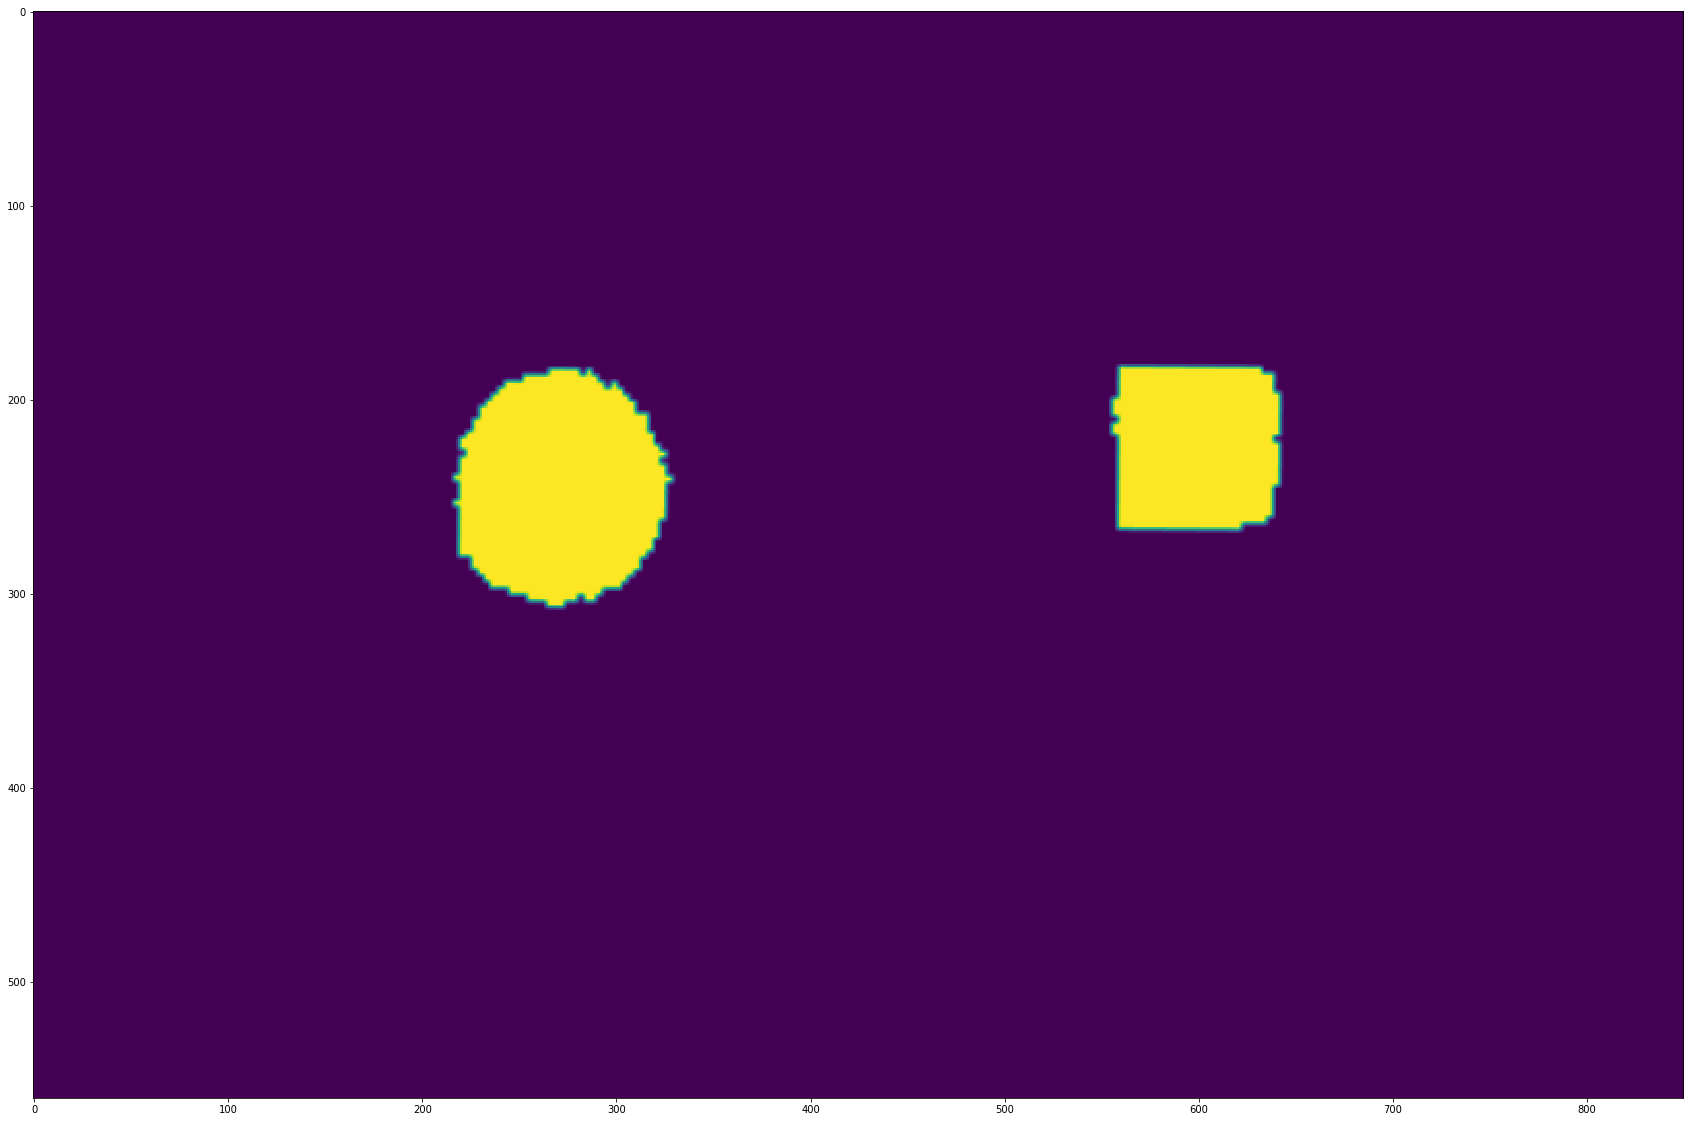

In [56]:
# use the approach from tutorial 6

# get transformation matrix
H, mask = cv2.findHomography(img_points, real_points)

conts_drawn_warped = cv2.warpPerspective(conts_drawn, H, (rasppi_width*10, rasppi_height*10))

plot_images(conts_drawn_warped)

In [67]:
_, _, conts = contours(conts_drawn_warped)

chip1_rect = cv2.minAreaRect(conts[0])[1]
chip2_rect = cv2.minAreaRect(conts[1])[1]

print('Microchip 1 area =', chip1_rect[0]/10 * chip1_rect[1]/10, 'mm^2')
print('Microchip 2 area =', chip2_rect[0]/10 * chip2_rect[1]/10, 'mm^2')
# the result seems okay (not great though)

Microchip 1 area = 143.75 mm^2
Microchip 2 area = 76.53999999999999 mm^2
